In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import random
from tqdm.auto import tqdm
from torch.utils.data import Subset
random.seed(42)

/home/idisc02/Desktop/Hewan/hlcv/Why-Self-Supervision-in-Time/.hlcv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TO DO: 
- Data Description, train, test split and their distribution

In [2]:
def select_percentage_of_train_dataset(dataset, percentage):
    class_counts = {}
    indices_by_class = {}

    # Count the number of samples in each class
    for idx, (_, label) in enumerate(dataset):
        if label not in class_counts:
            class_counts[label] = 0
            indices_by_class[label] = []
        class_counts[label] += 1
        indices_by_class[label].append(idx)

    selected_indices = []

    # Select a percentage of samples from each class
    for _, indices in indices_by_class.items():
        num_samples = int(len(indices) * percentage)
        selected_samples = random.sample(indices, num_samples)
        selected_indices.extend(selected_samples)

    selected_data = Subset(dataset, selected_indices)
    return selected_data


def model_def(backbone, training_type, weights, num_classes, device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model = backbone(weights=weights)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    if training_type == 'fine_tuning':
        for param in model.parameters():
            param.requires_grad = True
    elif training_type == 'linear_probe':
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    else:
        raise ValueError('Invalid training type!')
    return model.to(device)

def train_model(model, selected_train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device, save_dir):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    best_acc = 0.0
    best_loss = float('inf')

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch} of {num_epochs}')
        correct = 0
        iterations = 0
        iter_loss = 0.0

        model.train()  

        for i, (inputs, labels) in enumerate(selected_train_loader):
            if device:
                inputs = inputs.to(device)
                labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            iter_loss += loss.item() 
            optimizer.zero_grad() 
            loss.backward()  
            optimizer.step()  

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
            iterations += 1

        scheduler.step()

        train_loss.append(iter_loss / iterations)
        train_accuracy.append((100 * correct / len(selected_train_loader.dataset)))

        test_acc, test_losses = evaluate_model(model, test_loader, criterion, device)

        test_loss.append(test_losses)
        test_accuracy.append(test_acc)

        print(f'Epoch {epoch} Train results: Loss={train_loss[-1]:.4f} | Accuracy={train_accuracy[-1]:.2f}%')
        print(f'Epoch {epoch} Test results: Loss={test_loss[-1]:.4f} | Accuracy={test_accuracy[-1]:.2f}%\n')

        if test_acc > best_acc:
            best_acc = test_acc
            # torch.save(model.state_dict(), os.path.join(save_dir, 'best_acc_model.pth'))

        if test_losses < best_loss:
            best_loss = test_losses
            # torch.save(model.state_dict(), os.path.join(save_dir, 'best_loss_model.pth'))

    # Save the final model
    # torch.save(model.state_dict(), os.path.join(save_dir, 'final_model.pth'))

    return train_loss, train_accuracy, test_loss, test_accuracy


def evaluate_model(model, test_loader, criterion, device):
    model.eval()  
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            if device:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    return accuracy, test_loss

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = '/home/idisc02/Desktop/Hewan/hlcv/Why-Self-Supervision-in-Time/data/EuroSAT/'
batch_size = 64  
num_epochs = 20  
lr = 0.001  
weight_decay = 0.0005
init_idx = 0
backbone = [models.resnet50, models.resnet18][0]
init = [None, models.ResNet50_Weights.IMAGENET1K_V1, models.ResNet50_Weights.IMAGENET1K_V2]
img_size = 64
training_type = ['fine_tuning', 'linear_probe']


In [4]:
#Data transforms and dataloaders
data_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'train'), data_transforms)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [5]:
#count the number of images in each class
from collections import Counter
print(dict(Counter(test_dataset.targets)))

{0: 300, 1: 300, 2: 300, 3: 250, 4: 250, 5: 200, 6: 250, 7: 300, 8: 250, 9: 300}


In [7]:
#list with the percentage of the dataset to be used
percentage_list = np.arange(0.0, 1.1, 0.10)
percentage_list[0] = 0.01

In [8]:
save_dir = "/home/idisc02/Desktop/Hewan/hlcv/Why-Self-Supervision-in-Time/src/models"
train_acc_dict_percentage = {}
test_acc_dict_percentage = {}
train_loss_dict_percentage = {}
test_loss_dict_percentage = {}

for k in tqdm(init):
    print(k)
    for j in tqdm(training_type):
        print(j)
        for i in tqdm(range(len(percentage_list))):
            print(f'Percentage of the dataset used: {percentage_list[i]}')
            model = model_def(backbone, j, k, num_classes, device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            selected_train_dataset = select_percentage_of_train_dataset(train_dataset, percentage_list[i])
            selected_train_loader = DataLoader(selected_train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
            train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, selected_train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device, save_dir)

            train_acc_dict_percentage[f"{k}_{j}_{percentage_list[i]}"] = train_accuracy
            test_acc_dict_percentage[f"{k}_{j}_{percentage_list[i]}"] = test_accuracy
            train_loss_dict_percentage[f"{k}_{j}_{percentage_list[i]}"] = train_loss
            test_loss_dict_percentage[f"{k}_{j}_{percentage_list[i]}"] = test_loss
            

  0%|          | 0/3 [00:00<?, ?it/s]

None


fine_tuning


Percentage of the dataset used: 0.01
Epoch 1 of 20
Epoch 1 Train results: Loss=2.5747 | Accuracy=14.11%
Epoch 1 Test results: Loss=2.3511 | Accuracy=9.44%

Epoch 2 of 20
Epoch 2 Train results: Loss=2.1995 | Accuracy=25.31%
Epoch 2 Test results: Loss=2.3495 | Accuracy=12.63%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.8122 | Accuracy=36.93%
Epoch 3 Test results: Loss=2.4154 | Accuracy=19.48%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.4728 | Accuracy=45.23%
Epoch 4 Test results: Loss=2.5308 | Accuracy=21.74%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.3691 | Accuracy=57.26%
Epoch 5 Test results: Loss=2.7606 | Accuracy=20.89%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.2887 | Accuracy=53.11%
Epoch 6 Test results: Loss=2.2664 | Accuracy=26.33%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.0080 | Accuracy=69.71%
Epoch 7 Test results: Loss=2.4181 | Accuracy=29.89%

Epoch 8 of 20
Epoch 8 Train results: Loss=0.5431 | Accuracy=82.16%
Epoch 8 Test results: Loss=2.1942 | Accuracy=32.52%

Epoc

Epoch 20 Train results: Loss=0.0899 | Accuracy=98.76%
Epoch 20 Test results: Loss=1.5559 | Accuracy=57.93%

Percentage of the dataset used: 0.1
Epoch 1 of 20
Epoch 1 Train results: Loss=1.7615 | Accuracy=39.71%
Epoch 1 Test results: Loss=1.6883 | Accuracy=39.70%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.3871 | Accuracy=55.72%
Epoch 2 Test results: Loss=2.1579 | Accuracy=50.33%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.0395 | Accuracy=63.29%
Epoch 3 Test results: Loss=1.2288 | Accuracy=58.74%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.0135 | Accuracy=66.21%
Epoch 4 Test results: Loss=1.2063 | Accuracy=64.26%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.9352 | Accuracy=69.05%
Epoch 5 Test results: Loss=1.3046 | Accuracy=54.59%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.8009 | Accuracy=71.52%
Epoch 6 Test results: Loss=0.8175 | Accuracy=72.41%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.7399 | Accuracy=74.90%
Epoch 7 Test results: Loss=1.0181 | Accuracy=64.30%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0754 | Accuracy=97.70%
Epoch 20 Test results: Loss=0.7377 | Accuracy=80.56%

Percentage of the dataset used: 0.2
Epoch 1 of 20
Epoch 1 Train results: Loss=1.5521 | Accuracy=49.36%
Epoch 1 Test results: Loss=3.1136 | Accuracy=42.48%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.0442 | Accuracy=64.73%
Epoch 2 Test results: Loss=2.3837 | Accuracy=44.26%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.9714 | Accuracy=65.43%
Epoch 3 Test results: Loss=1.3467 | Accuracy=55.48%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.8122 | Accuracy=71.50%
Epoch 4 Test results: Loss=1.4982 | Accuracy=60.04%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.7569 | Accuracy=74.18%
Epoch 5 Test results: Loss=0.8403 | Accuracy=73.48%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.0005 | Accuracy=68.68%
Epoch 6 Test results: Loss=0.8765 | Accuracy=67.07%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.7213 | Accuracy=75.04%
Epoch 7 Test results: Loss=0.9525 | Accuracy=66.33%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.1109 | Accuracy=96.85%
Epoch 20 Test results: Loss=0.5458 | Accuracy=84.33%

Percentage of the dataset used: 0.30000000000000004
Epoch 1 of 20
Epoch 1 Train results: Loss=1.4155 | Accuracy=52.28%
Epoch 1 Test results: Loss=1.1748 | Accuracy=57.11%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.0486 | Accuracy=65.65%
Epoch 2 Test results: Loss=11.8931 | Accuracy=55.78%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.9168 | Accuracy=68.85%
Epoch 3 Test results: Loss=1.0602 | Accuracy=62.33%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.7846 | Accuracy=73.03%
Epoch 4 Test results: Loss=1.1483 | Accuracy=66.37%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.7184 | Accuracy=75.58%
Epoch 5 Test results: Loss=0.8733 | Accuracy=67.96%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.6408 | Accuracy=78.24%
Epoch 6 Test results: Loss=0.7167 | Accuracy=75.52%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.5839 | Accuracy=80.10%
Epoch 7 Test results: Loss=1.4851 | Accuracy=53.63%


Epoch 20 Train results: Loss=0.0550 | Accuracy=98.23%
Epoch 20 Test results: Loss=0.4899 | Accuracy=87.00%

Percentage of the dataset used: 0.4
Epoch 1 of 20
Epoch 1 Train results: Loss=1.2570 | Accuracy=57.25%
Epoch 1 Test results: Loss=2.0533 | Accuracy=53.15%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.9151 | Accuracy=68.89%
Epoch 2 Test results: Loss=1.5951 | Accuracy=58.26%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.7933 | Accuracy=73.18%
Epoch 3 Test results: Loss=1.0565 | Accuracy=67.22%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.6762 | Accuracy=76.68%
Epoch 4 Test results: Loss=0.7043 | Accuracy=74.93%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.6031 | Accuracy=79.74%
Epoch 5 Test results: Loss=0.6893 | Accuracy=75.56%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.5450 | Accuracy=81.58%
Epoch 6 Test results: Loss=0.9593 | Accuracy=71.41%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.5126 | Accuracy=82.88%
Epoch 7 Test results: Loss=0.4900 | Accuracy=84.19%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0324 | Accuracy=99.02%
Epoch 20 Test results: Loss=0.3758 | Accuracy=90.15%

Percentage of the dataset used: 0.5
Epoch 1 of 20
Epoch 1 Train results: Loss=1.2752 | Accuracy=57.56%
Epoch 1 Test results: Loss=1.9819 | Accuracy=50.78%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.9156 | Accuracy=68.95%
Epoch 2 Test results: Loss=0.9231 | Accuracy=68.59%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.7205 | Accuracy=75.69%
Epoch 3 Test results: Loss=1.3625 | Accuracy=62.04%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.7004 | Accuracy=76.40%
Epoch 4 Test results: Loss=1.1761 | Accuracy=64.37%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.6005 | Accuracy=79.68%
Epoch 5 Test results: Loss=0.8395 | Accuracy=73.11%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.5248 | Accuracy=82.44%
Epoch 6 Test results: Loss=0.5606 | Accuracy=79.96%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.5051 | Accuracy=83.16%
Epoch 7 Test results: Loss=0.6410 | Accuracy=79.59%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0360 | Accuracy=98.92%
Epoch 20 Test results: Loss=0.3375 | Accuracy=90.59%

Percentage of the dataset used: 0.6000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=1.1691 | Accuracy=60.02%
Epoch 1 Test results: Loss=5.3371 | Accuracy=49.22%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.9536 | Accuracy=68.05%
Epoch 2 Test results: Loss=0.8492 | Accuracy=71.56%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.7370 | Accuracy=75.06%
Epoch 3 Test results: Loss=1.3371 | Accuracy=61.59%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.6569 | Accuracy=77.28%
Epoch 4 Test results: Loss=1.0205 | Accuracy=71.74%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.6144 | Accuracy=78.85%
Epoch 5 Test results: Loss=0.8162 | Accuracy=70.59%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.5292 | Accuracy=81.84%
Epoch 6 Test results: Loss=0.4863 | Accuracy=83.81%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.5055 | Accuracy=82.96%
Epoch 7 Test results: Loss=0.8149 | Accuracy=69.48%

E

Epoch 20 Train results: Loss=0.0463 | Accuracy=98.62%
Epoch 20 Test results: Loss=0.2795 | Accuracy=92.41%

Percentage of the dataset used: 0.7000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=1.2131 | Accuracy=60.17%
Epoch 1 Test results: Loss=5.3867 | Accuracy=49.70%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.8291 | Accuracy=71.90%
Epoch 2 Test results: Loss=1.1510 | Accuracy=65.33%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.6753 | Accuracy=77.06%
Epoch 3 Test results: Loss=0.5830 | Accuracy=80.44%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.5932 | Accuracy=79.94%
Epoch 4 Test results: Loss=0.6245 | Accuracy=77.26%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.5186 | Accuracy=82.48%
Epoch 5 Test results: Loss=0.8735 | Accuracy=71.52%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.4917 | Accuracy=83.66%
Epoch 6 Test results: Loss=1.1715 | Accuracy=67.81%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.4532 | Accuracy=85.04%
Epoch 7 Test results: Loss=0.4398 | Accuracy=85.63%

E

Epoch 20 Train results: Loss=0.0378 | Accuracy=98.98%
Epoch 20 Test results: Loss=0.2172 | Accuracy=94.04%

Percentage of the dataset used: 0.8
Epoch 1 of 20
Epoch 1 Train results: Loss=1.1623 | Accuracy=60.37%
Epoch 1 Test results: Loss=1.7636 | Accuracy=50.48%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.7856 | Accuracy=73.40%
Epoch 2 Test results: Loss=1.2711 | Accuracy=61.81%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.6404 | Accuracy=78.16%
Epoch 3 Test results: Loss=0.8283 | Accuracy=71.74%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.5615 | Accuracy=80.94%
Epoch 4 Test results: Loss=0.6892 | Accuracy=76.81%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.5040 | Accuracy=82.99%
Epoch 5 Test results: Loss=0.7050 | Accuracy=75.78%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.4540 | Accuracy=84.95%
Epoch 6 Test results: Loss=0.5257 | Accuracy=81.70%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.4205 | Accuracy=85.96%
Epoch 7 Test results: Loss=0.4821 | Accuracy=83.89%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0391 | Accuracy=99.02%
Epoch 20 Test results: Loss=0.1792 | Accuracy=94.89%

Percentage of the dataset used: 0.9
Epoch 1 of 20
Epoch 1 Train results: Loss=1.1529 | Accuracy=60.97%
Epoch 1 Test results: Loss=0.8576 | Accuracy=71.44%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.8081 | Accuracy=72.37%
Epoch 2 Test results: Loss=0.7817 | Accuracy=72.59%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.6799 | Accuracy=76.41%
Epoch 3 Test results: Loss=0.5879 | Accuracy=80.04%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.5681 | Accuracy=80.54%
Epoch 4 Test results: Loss=0.6738 | Accuracy=77.93%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.5036 | Accuracy=83.14%
Epoch 5 Test results: Loss=0.7646 | Accuracy=76.63%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.4732 | Accuracy=84.01%
Epoch 6 Test results: Loss=0.5449 | Accuracy=80.59%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.4411 | Accuracy=85.50%
Epoch 7 Test results: Loss=0.5773 | Accuracy=80.93%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0504 | Accuracy=98.57%
Epoch 20 Test results: Loss=0.1676 | Accuracy=94.26%

Percentage of the dataset used: 1.0
Epoch 1 of 20
Epoch 1 Train results: Loss=1.1109 | Accuracy=62.71%
Epoch 1 Test results: Loss=1.2325 | Accuracy=62.41%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.7405 | Accuracy=75.02%
Epoch 2 Test results: Loss=4.0943 | Accuracy=43.67%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.6049 | Accuracy=79.92%
Epoch 3 Test results: Loss=0.5957 | Accuracy=78.67%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.5227 | Accuracy=82.37%
Epoch 4 Test results: Loss=1.2439 | Accuracy=68.22%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.4694 | Accuracy=84.30%
Epoch 5 Test results: Loss=0.4835 | Accuracy=83.85%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.4328 | Accuracy=85.75%
Epoch 6 Test results: Loss=0.5294 | Accuracy=81.48%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3891 | Accuracy=87.25%
Epoch 7 Test results: Loss=0.8109 | Accuracy=78.81%

Epoch 8 of 20
Ep


100%|██████████| 11/11 [31:24<00:00, 171.32s/it]


Epoch 20 Train results: Loss=0.0391 | Accuracy=99.06%
Epoch 20 Test results: Loss=0.1304 | Accuracy=96.04%

linear_probe


Percentage of the dataset used: 0.01
Epoch 1 of 20
Epoch 1 Train results: Loss=2.6682 | Accuracy=12.45%
Epoch 1 Test results: Loss=2.3091 | Accuracy=11.11%

Epoch 2 of 20
Epoch 2 Train results: Loss=2.3395 | Accuracy=16.60%
Epoch 2 Test results: Loss=2.3732 | Accuracy=11.11%

Epoch 3 of 20
Epoch 3 Train results: Loss=2.2354 | Accuracy=17.43%
Epoch 3 Test results: Loss=2.4257 | Accuracy=11.44%

Epoch 4 of 20
Epoch 4 Train results: Loss=2.0368 | Accuracy=22.82%
Epoch 4 Test results: Loss=2.4709 | Accuracy=11.11%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.9701 | Accuracy=29.88%
Epoch 5 Test results: Loss=2.5316 | Accuracy=11.11%

Epoch 6 of 20
Epoch 6 Train results: Loss=2.0335 | Accuracy=29.88%
Epoch 6 Test results: Loss=2.6833 | Accuracy=11.11%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.9542 | Accuracy=23.65%
Epoch 7 Test results: Loss=2.5890 | Accuracy=14.78%

Epoch 8 of 20
Epoch 8 Train results: Loss=1.8864 | Accuracy=31.12%
Epoch 8 Test results: Loss=2.4992 | Accuracy=16.00%

Epo

Epoch 20 Train results: Loss=1.8101 | Accuracy=36.10%
Epoch 20 Test results: Loss=1.9412 | Accuracy=28.63%

Percentage of the dataset used: 0.1
Epoch 1 of 20
Epoch 1 Train results: Loss=2.2341 | Accuracy=20.37%
Epoch 1 Test results: Loss=2.3526 | Accuracy=15.78%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.9764 | Accuracy=28.02%
Epoch 2 Test results: Loss=1.9304 | Accuracy=34.07%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.9502 | Accuracy=30.41%
Epoch 3 Test results: Loss=2.0757 | Accuracy=30.48%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.9151 | Accuracy=34.32%
Epoch 4 Test results: Loss=1.8259 | Accuracy=35.56%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.7697 | Accuracy=39.01%
Epoch 5 Test results: Loss=1.8135 | Accuracy=37.30%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.8543 | Accuracy=36.58%
Epoch 6 Test results: Loss=1.8110 | Accuracy=39.48%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.7669 | Accuracy=38.31%
Epoch 7 Test results: Loss=1.7312 | Accuracy=38.44%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=1.5751 | Accuracy=45.80%
Epoch 20 Test results: Loss=1.6416 | Accuracy=42.37%

Percentage of the dataset used: 0.2
Epoch 1 of 20
Epoch 1 Train results: Loss=2.1407 | Accuracy=24.20%
Epoch 1 Test results: Loss=1.9349 | Accuracy=27.41%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.9425 | Accuracy=30.82%
Epoch 2 Test results: Loss=1.9180 | Accuracy=29.70%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.8096 | Accuracy=35.68%
Epoch 3 Test results: Loss=1.7594 | Accuracy=40.85%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.7638 | Accuracy=38.02%
Epoch 4 Test results: Loss=1.6472 | Accuracy=41.67%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.7172 | Accuracy=40.04%
Epoch 5 Test results: Loss=1.8072 | Accuracy=36.63%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.7220 | Accuracy=39.90%
Epoch 6 Test results: Loss=1.8023 | Accuracy=39.93%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.6330 | Accuracy=42.96%
Epoch 7 Test results: Loss=1.7083 | Accuracy=42.63%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=1.4736 | Accuracy=49.61%
Epoch 20 Test results: Loss=1.5114 | Accuracy=47.78%

Percentage of the dataset used: 0.30000000000000004
Epoch 1 of 20
Epoch 1 Train results: Loss=2.0466 | Accuracy=27.00%
Epoch 1 Test results: Loss=1.9011 | Accuracy=31.11%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.8257 | Accuracy=35.08%
Epoch 2 Test results: Loss=1.6825 | Accuracy=40.33%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.7154 | Accuracy=38.46%
Epoch 3 Test results: Loss=1.6422 | Accuracy=40.41%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.6892 | Accuracy=39.97%
Epoch 4 Test results: Loss=1.6578 | Accuracy=43.33%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.6317 | Accuracy=42.39%
Epoch 5 Test results: Loss=1.6429 | Accuracy=41.59%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.5912 | Accuracy=43.33%
Epoch 6 Test results: Loss=1.5260 | Accuracy=44.74%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.5863 | Accuracy=44.05%
Epoch 7 Test results: Loss=1.5168 | Accuracy=46.63%



Epoch 20 Train results: Loss=1.4217 | Accuracy=49.59%
Epoch 20 Test results: Loss=1.4466 | Accuracy=48.33%

Percentage of the dataset used: 0.4
Epoch 1 of 20
Epoch 1 Train results: Loss=1.9951 | Accuracy=28.78%
Epoch 1 Test results: Loss=1.9227 | Accuracy=36.85%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.7848 | Accuracy=37.16%
Epoch 2 Test results: Loss=1.7009 | Accuracy=42.93%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.6728 | Accuracy=40.92%
Epoch 3 Test results: Loss=1.6459 | Accuracy=45.52%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.6323 | Accuracy=42.76%
Epoch 4 Test results: Loss=1.5825 | Accuracy=42.74%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.5873 | Accuracy=44.15%
Epoch 5 Test results: Loss=1.6199 | Accuracy=44.26%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.5519 | Accuracy=45.53%
Epoch 6 Test results: Loss=1.5466 | Accuracy=44.33%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.5323 | Accuracy=45.50%
Epoch 7 Test results: Loss=1.4821 | Accuracy=50.26%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=1.3946 | Accuracy=50.93%
Epoch 20 Test results: Loss=1.4105 | Accuracy=50.30%

Percentage of the dataset used: 0.5
Epoch 1 of 20
Epoch 1 Train results: Loss=1.9234 | Accuracy=30.12%
Epoch 1 Test results: Loss=1.7134 | Accuracy=36.89%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.7308 | Accuracy=37.86%
Epoch 2 Test results: Loss=1.7617 | Accuracy=35.15%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.6279 | Accuracy=41.74%
Epoch 3 Test results: Loss=1.5831 | Accuracy=42.19%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.5707 | Accuracy=43.88%
Epoch 4 Test results: Loss=1.5891 | Accuracy=44.48%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.5858 | Accuracy=43.79%
Epoch 5 Test results: Loss=1.5530 | Accuracy=43.85%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.5381 | Accuracy=45.25%
Epoch 6 Test results: Loss=1.5079 | Accuracy=47.70%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.4969 | Accuracy=46.70%
Epoch 7 Test results: Loss=1.4132 | Accuracy=48.67%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=1.3748 | Accuracy=51.42%
Epoch 20 Test results: Loss=1.3807 | Accuracy=49.70%

Percentage of the dataset used: 0.6000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=1.9537 | Accuracy=30.04%
Epoch 1 Test results: Loss=1.7642 | Accuracy=35.11%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.7313 | Accuracy=38.66%
Epoch 2 Test results: Loss=1.6409 | Accuracy=45.41%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.6432 | Accuracy=41.87%
Epoch 3 Test results: Loss=1.7327 | Accuracy=41.63%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.5851 | Accuracy=43.61%
Epoch 4 Test results: Loss=1.5000 | Accuracy=47.11%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.5397 | Accuracy=45.35%
Epoch 5 Test results: Loss=1.5278 | Accuracy=49.00%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.5288 | Accuracy=46.34%
Epoch 6 Test results: Loss=1.5582 | Accuracy=44.74%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.5178 | Accuracy=46.29%
Epoch 7 Test results: Loss=1.5815 | Accuracy=46.37%

E

Epoch 20 Train results: Loss=1.3703 | Accuracy=51.92%
Epoch 20 Test results: Loss=1.3610 | Accuracy=51.37%

Percentage of the dataset used: 0.7000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=1.8698 | Accuracy=33.90%
Epoch 1 Test results: Loss=1.6631 | Accuracy=40.63%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.6417 | Accuracy=41.85%
Epoch 2 Test results: Loss=1.5540 | Accuracy=45.19%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.5958 | Accuracy=44.16%
Epoch 3 Test results: Loss=1.5453 | Accuracy=47.11%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.5476 | Accuracy=46.16%
Epoch 4 Test results: Loss=1.4476 | Accuracy=49.74%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.5038 | Accuracy=46.48%
Epoch 5 Test results: Loss=1.4014 | Accuracy=50.70%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.4707 | Accuracy=47.55%
Epoch 6 Test results: Loss=1.4073 | Accuracy=51.15%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.4785 | Accuracy=47.98%
Epoch 7 Test results: Loss=1.5106 | Accuracy=44.70%

E

Epoch 20 Train results: Loss=1.3332 | Accuracy=52.40%
Epoch 20 Test results: Loss=1.3363 | Accuracy=52.70%

Percentage of the dataset used: 0.8
Epoch 1 of 20
Epoch 1 Train results: Loss=1.8689 | Accuracy=33.36%
Epoch 1 Test results: Loss=1.6201 | Accuracy=42.93%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.6828 | Accuracy=40.73%
Epoch 2 Test results: Loss=1.6557 | Accuracy=43.37%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.6130 | Accuracy=43.17%
Epoch 3 Test results: Loss=1.5043 | Accuracy=46.63%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.5517 | Accuracy=45.65%
Epoch 4 Test results: Loss=1.4530 | Accuracy=47.81%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.5153 | Accuracy=46.29%
Epoch 5 Test results: Loss=1.4903 | Accuracy=45.44%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.5114 | Accuracy=46.78%
Epoch 6 Test results: Loss=1.5413 | Accuracy=44.30%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.5077 | Accuracy=46.99%
Epoch 7 Test results: Loss=1.4299 | Accuracy=49.70%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=1.3553 | Accuracy=52.25%
Epoch 20 Test results: Loss=1.3289 | Accuracy=53.04%

Percentage of the dataset used: 0.9
Epoch 1 of 20
Epoch 1 Train results: Loss=1.9011 | Accuracy=32.84%
Epoch 1 Test results: Loss=1.6320 | Accuracy=42.81%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.6987 | Accuracy=40.68%
Epoch 2 Test results: Loss=1.6031 | Accuracy=43.19%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.6153 | Accuracy=43.45%
Epoch 3 Test results: Loss=1.5401 | Accuracy=45.00%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.5694 | Accuracy=44.78%
Epoch 4 Test results: Loss=1.6161 | Accuracy=45.30%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.5533 | Accuracy=45.38%
Epoch 5 Test results: Loss=1.4920 | Accuracy=47.37%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.5148 | Accuracy=46.79%
Epoch 6 Test results: Loss=1.4853 | Accuracy=46.63%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.5080 | Accuracy=47.16%
Epoch 7 Test results: Loss=1.5001 | Accuracy=46.44%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=1.3768 | Accuracy=51.21%
Epoch 20 Test results: Loss=1.3631 | Accuracy=52.37%

Percentage of the dataset used: 1.0
Epoch 1 of 20
Epoch 1 Train results: Loss=1.8891 | Accuracy=33.31%
Epoch 1 Test results: Loss=1.8093 | Accuracy=36.22%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.6736 | Accuracy=41.14%
Epoch 2 Test results: Loss=1.5416 | Accuracy=45.19%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.6001 | Accuracy=43.93%
Epoch 3 Test results: Loss=1.5275 | Accuracy=46.07%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.5623 | Accuracy=45.21%
Epoch 4 Test results: Loss=1.5274 | Accuracy=47.00%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.5306 | Accuracy=45.78%
Epoch 5 Test results: Loss=1.4854 | Accuracy=45.85%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.5273 | Accuracy=46.58%
Epoch 6 Test results: Loss=1.5271 | Accuracy=46.89%

Epoch 7 of 20
Epoch 7 Train results: Loss=1.5191 | Accuracy=46.40%
Epoch 7 Test results: Loss=1.4706 | Accuracy=46.30%

Epoch 8 of 20
Ep


 33%|███▎      | 1/3 [43:00<1:26:01, 2580.73s/it]

ResNet50_Weights.IMAGENET1K_V1


fine_tuning


Percentage of the dataset used: 0.01
Epoch 1 of 20
Epoch 1 Train results: Loss=1.5804 | Accuracy=42.32%
Epoch 1 Test results: Loss=10.1537 | Accuracy=24.04%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.4327 | Accuracy=90.04%
Epoch 2 Test results: Loss=8.5335 | Accuracy=32.78%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.4245 | Accuracy=88.80%
Epoch 3 Test results: Loss=2.6870 | Accuracy=54.81%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.2042 | Accuracy=92.95%
Epoch 4 Test results: Loss=4.5705 | Accuracy=55.00%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1968 | Accuracy=95.02%
Epoch 5 Test results: Loss=4.9434 | Accuracy=45.74%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.2614 | Accuracy=94.19%
Epoch 6 Test results: Loss=4.3746 | Accuracy=59.07%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3206 | Accuracy=93.78%
Epoch 7 Test results: Loss=4.8892 | Accuracy=61.70%

Epoch 8 of 20
Epoch 8 Train results: Loss=0.1435 | Accuracy=97.51%
Epoch 8 Test results: Loss=2.6078 | Accuracy=68.52%

Ep

Percentage of the dataset used: 0.1
Epoch 1 of 20
Epoch 1 Train results: Loss=0.8602 | Accuracy=72.88%
Epoch 1 Test results: Loss=1.6650 | Accuracy=73.00%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.4323 | Accuracy=87.82%
Epoch 2 Test results: Loss=0.5986 | Accuracy=82.22%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.2897 | Accuracy=91.15%
Epoch 3 Test results: Loss=0.6519 | Accuracy=80.74%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.2770 | Accuracy=91.56%
Epoch 4 Test results: Loss=0.5622 | Accuracy=85.15%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1964 | Accuracy=94.44%
Epoch 5 Test results: Loss=0.5391 | Accuracy=84.11%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1528 | Accuracy=95.35%
Epoch 6 Test results: Loss=0.3701 | Accuracy=89.11%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1644 | Accuracy=95.27%
Epoch 7 Test results: Loss=0.3733 | Accuracy=89.00%

Epoch 8 of 20
Epoch 8 Train results: Loss=0.0751 | Accuracy=97.53%
Epoch 8 Test results: Loss=0.2049 | Accuracy=94.07%

Epoc

Epoch 20 Train results: Loss=0.0076 | Accuracy=99.75%
Epoch 20 Test results: Loss=0.2109 | Accuracy=94.41%

Percentage of the dataset used: 0.2
Epoch 1 of 20
Epoch 1 Train results: Loss=0.6861 | Accuracy=79.20%
Epoch 1 Test results: Loss=0.3695 | Accuracy=88.52%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.3338 | Accuracy=90.06%
Epoch 2 Test results: Loss=0.2731 | Accuracy=91.19%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.2995 | Accuracy=90.51%
Epoch 3 Test results: Loss=0.3074 | Accuracy=90.22%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.2002 | Accuracy=93.74%
Epoch 4 Test results: Loss=0.3722 | Accuracy=88.19%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1774 | Accuracy=94.38%
Epoch 5 Test results: Loss=0.2661 | Accuracy=91.33%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1673 | Accuracy=95.02%
Epoch 6 Test results: Loss=0.3620 | Accuracy=89.15%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1421 | Accuracy=95.66%
Epoch 7 Test results: Loss=0.5033 | Accuracy=84.89%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0074 | Accuracy=99.84%
Epoch 20 Test results: Loss=0.1521 | Accuracy=95.74%

Percentage of the dataset used: 0.30000000000000004
Epoch 1 of 20
Epoch 1 Train results: Loss=0.6278 | Accuracy=80.47%
Epoch 1 Test results: Loss=0.5677 | Accuracy=82.96%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2770 | Accuracy=91.14%
Epoch 2 Test results: Loss=0.3663 | Accuracy=88.67%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.2395 | Accuracy=92.66%
Epoch 3 Test results: Loss=0.3228 | Accuracy=90.59%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1855 | Accuracy=94.25%
Epoch 4 Test results: Loss=0.2511 | Accuracy=92.56%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1904 | Accuracy=94.36%
Epoch 5 Test results: Loss=0.3500 | Accuracy=88.56%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1817 | Accuracy=94.53%
Epoch 6 Test results: Loss=0.5102 | Accuracy=84.63%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1532 | Accuracy=95.27%
Epoch 7 Test results: Loss=0.3317 | Accuracy=90.52%



Epoch 20 Train results: Loss=0.0045 | Accuracy=99.92%
Epoch 20 Test results: Loss=0.1184 | Accuracy=96.74%

Percentage of the dataset used: 0.4
Epoch 1 of 20
Epoch 1 Train results: Loss=0.5295 | Accuracy=83.95%
Epoch 1 Test results: Loss=0.4036 | Accuracy=87.37%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2717 | Accuracy=91.59%
Epoch 2 Test results: Loss=1.7273 | Accuracy=68.33%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.2738 | Accuracy=91.46%
Epoch 3 Test results: Loss=0.2174 | Accuracy=92.37%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.2055 | Accuracy=93.57%
Epoch 4 Test results: Loss=0.3457 | Accuracy=89.00%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1724 | Accuracy=94.38%
Epoch 5 Test results: Loss=0.3174 | Accuracy=90.07%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1685 | Accuracy=94.42%
Epoch 6 Test results: Loss=0.2385 | Accuracy=91.96%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1532 | Accuracy=95.15%
Epoch 7 Test results: Loss=0.7545 | Accuracy=76.15%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0036 | Accuracy=99.95%
Epoch 20 Test results: Loss=0.1025 | Accuracy=97.19%

Percentage of the dataset used: 0.5
Epoch 1 of 20
Epoch 1 Train results: Loss=0.5003 | Accuracy=85.15%
Epoch 1 Test results: Loss=0.3388 | Accuracy=89.67%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2375 | Accuracy=92.42%
Epoch 2 Test results: Loss=0.7113 | Accuracy=80.59%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.2134 | Accuracy=93.12%
Epoch 3 Test results: Loss=1.3703 | Accuracy=67.74%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1989 | Accuracy=93.74%
Epoch 4 Test results: Loss=0.3406 | Accuracy=89.59%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1813 | Accuracy=94.22%
Epoch 5 Test results: Loss=0.1817 | Accuracy=94.44%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1809 | Accuracy=93.99%
Epoch 6 Test results: Loss=0.2090 | Accuracy=93.52%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1672 | Accuracy=94.49%
Epoch 7 Test results: Loss=0.3916 | Accuracy=87.37%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0057 | Accuracy=99.88%
Epoch 20 Test results: Loss=0.0987 | Accuracy=97.11%

Percentage of the dataset used: 0.6000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=0.4622 | Accuracy=85.64%
Epoch 1 Test results: Loss=0.2664 | Accuracy=91.44%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2520 | Accuracy=91.98%
Epoch 2 Test results: Loss=0.3821 | Accuracy=87.70%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.2252 | Accuracy=92.59%
Epoch 3 Test results: Loss=0.6675 | Accuracy=82.11%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1957 | Accuracy=93.85%
Epoch 4 Test results: Loss=0.5395 | Accuracy=82.85%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1771 | Accuracy=94.31%
Epoch 5 Test results: Loss=0.2611 | Accuracy=91.37%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1902 | Accuracy=93.86%
Epoch 6 Test results: Loss=0.2098 | Accuracy=93.41%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1698 | Accuracy=94.60%
Epoch 7 Test results: Loss=0.4785 | Accuracy=86.11%

E

Epoch 20 Train results: Loss=0.0060 | Accuracy=99.92%
Epoch 20 Test results: Loss=0.0998 | Accuracy=97.30%

Percentage of the dataset used: 0.7000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=0.4642 | Accuracy=85.93%
Epoch 1 Test results: Loss=0.4045 | Accuracy=87.30%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2534 | Accuracy=92.00%
Epoch 2 Test results: Loss=0.2340 | Accuracy=92.67%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.2127 | Accuracy=93.21%
Epoch 3 Test results: Loss=0.2853 | Accuracy=90.63%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.2011 | Accuracy=93.48%
Epoch 4 Test results: Loss=0.3805 | Accuracy=88.22%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1820 | Accuracy=94.02%
Epoch 5 Test results: Loss=0.1831 | Accuracy=94.00%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1845 | Accuracy=93.96%
Epoch 6 Test results: Loss=0.6288 | Accuracy=82.52%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1628 | Accuracy=94.82%
Epoch 7 Test results: Loss=0.2851 | Accuracy=91.00%

E

Epoch 20 Train results: Loss=0.0056 | Accuracy=99.89%
Epoch 20 Test results: Loss=0.0786 | Accuracy=97.67%

Percentage of the dataset used: 0.8
Epoch 1 of 20
Epoch 1 Train results: Loss=0.4279 | Accuracy=86.97%
Epoch 1 Test results: Loss=0.3326 | Accuracy=89.81%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2334 | Accuracy=92.75%
Epoch 2 Test results: Loss=0.2282 | Accuracy=93.19%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.2293 | Accuracy=92.66%
Epoch 3 Test results: Loss=0.4272 | Accuracy=86.89%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1991 | Accuracy=93.62%
Epoch 4 Test results: Loss=0.4985 | Accuracy=86.00%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1789 | Accuracy=94.13%
Epoch 5 Test results: Loss=0.2555 | Accuracy=91.52%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1800 | Accuracy=94.20%
Epoch 6 Test results: Loss=0.4852 | Accuracy=84.33%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1793 | Accuracy=94.30%
Epoch 7 Test results: Loss=0.5684 | Accuracy=86.52%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0063 | Accuracy=99.91%
Epoch 20 Test results: Loss=0.0839 | Accuracy=98.04%

Percentage of the dataset used: 0.9
Epoch 1 of 20
Epoch 1 Train results: Loss=0.4137 | Accuracy=87.34%
Epoch 1 Test results: Loss=0.5173 | Accuracy=86.78%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2360 | Accuracy=92.34%
Epoch 2 Test results: Loss=0.3522 | Accuracy=89.26%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.2142 | Accuracy=93.16%
Epoch 3 Test results: Loss=0.2058 | Accuracy=93.22%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1931 | Accuracy=93.85%
Epoch 4 Test results: Loss=0.7078 | Accuracy=81.41%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1773 | Accuracy=94.18%
Epoch 5 Test results: Loss=0.7760 | Accuracy=81.89%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1888 | Accuracy=93.77%
Epoch 6 Test results: Loss=0.1838 | Accuracy=93.81%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1666 | Accuracy=94.58%
Epoch 7 Test results: Loss=0.2512 | Accuracy=91.96%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0057 | Accuracy=99.93%
Epoch 20 Test results: Loss=0.0798 | Accuracy=97.78%

Percentage of the dataset used: 1.0
Epoch 1 of 20
Epoch 1 Train results: Loss=0.3980 | Accuracy=87.69%
Epoch 1 Test results: Loss=0.4818 | Accuracy=85.93%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2471 | Accuracy=92.19%
Epoch 2 Test results: Loss=0.2630 | Accuracy=90.81%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.2076 | Accuracy=93.19%
Epoch 3 Test results: Loss=0.2778 | Accuracy=91.00%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1969 | Accuracy=93.78%
Epoch 4 Test results: Loss=0.2445 | Accuracy=92.11%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1899 | Accuracy=93.86%
Epoch 5 Test results: Loss=0.1929 | Accuracy=93.70%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1844 | Accuracy=94.07%
Epoch 6 Test results: Loss=0.2454 | Accuracy=92.59%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1795 | Accuracy=94.05%
Epoch 7 Test results: Loss=0.9279 | Accuracy=82.52%

Epoch 8 of 20
Ep


100%|██████████| 11/11 [31:26<00:00, 171.50s/it]


Epoch 20 Train results: Loss=0.0074 | Accuracy=99.88%
Epoch 20 Test results: Loss=0.0756 | Accuracy=98.04%

linear_probe


Percentage of the dataset used: 0.01
Epoch 1 of 20
Epoch 1 Train results: Loss=2.2629 | Accuracy=18.67%
Epoch 1 Test results: Loss=1.9649 | Accuracy=33.59%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.7111 | Accuracy=52.70%
Epoch 2 Test results: Loss=1.7202 | Accuracy=48.11%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.2428 | Accuracy=77.59%
Epoch 3 Test results: Loss=1.4822 | Accuracy=62.59%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.9694 | Accuracy=87.97%
Epoch 4 Test results: Loss=1.3108 | Accuracy=64.41%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.7227 | Accuracy=91.29%
Epoch 5 Test results: Loss=1.1589 | Accuracy=67.78%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.6041 | Accuracy=93.78%
Epoch 6 Test results: Loss=1.0537 | Accuracy=71.22%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.5169 | Accuracy=93.36%
Epoch 7 Test results: Loss=0.9802 | Accuracy=72.93%

Epoch 8 of 20
Epoch 8 Train results: Loss=0.4499 | Accuracy=95.44%
Epoch 8 Test results: Loss=0.9683 | Accuracy=73.48%

Epo

Epoch 20 Train results: Loss=0.3959 | Accuracy=97.51%
Epoch 20 Test results: Loss=0.9366 | Accuracy=73.59%

Percentage of the dataset used: 0.1
Epoch 1 of 20
Epoch 1 Train results: Loss=1.2805 | Accuracy=63.33%
Epoch 1 Test results: Loss=0.7768 | Accuracy=78.59%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.6237 | Accuracy=82.06%
Epoch 2 Test results: Loss=0.6240 | Accuracy=81.56%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.5098 | Accuracy=84.49%
Epoch 3 Test results: Loss=0.5815 | Accuracy=82.74%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.4213 | Accuracy=87.90%
Epoch 4 Test results: Loss=0.5494 | Accuracy=83.07%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3725 | Accuracy=89.30%
Epoch 5 Test results: Loss=0.5264 | Accuracy=83.67%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3306 | Accuracy=90.04%
Epoch 6 Test results: Loss=0.4960 | Accuracy=84.52%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3177 | Accuracy=90.49%
Epoch 7 Test results: Loss=0.5041 | Accuracy=84.15%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.2518 | Accuracy=93.25%
Epoch 20 Test results: Loss=0.4689 | Accuracy=85.00%

Percentage of the dataset used: 0.2
Epoch 1 of 20
Epoch 1 Train results: Loss=1.0226 | Accuracy=70.19%
Epoch 1 Test results: Loss=0.5977 | Accuracy=84.19%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.5239 | Accuracy=84.09%
Epoch 2 Test results: Loss=0.5135 | Accuracy=84.56%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.4466 | Accuracy=86.23%
Epoch 3 Test results: Loss=0.4923 | Accuracy=85.41%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.3900 | Accuracy=88.19%
Epoch 4 Test results: Loss=0.4528 | Accuracy=86.44%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3509 | Accuracy=89.32%
Epoch 5 Test results: Loss=0.4775 | Accuracy=85.63%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3380 | Accuracy=89.63%
Epoch 6 Test results: Loss=0.4770 | Accuracy=85.63%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3178 | Accuracy=89.96%
Epoch 7 Test results: Loss=0.4336 | Accuracy=87.15%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.2390 | Accuracy=93.31%
Epoch 20 Test results: Loss=0.4176 | Accuracy=87.48%

Percentage of the dataset used: 0.30000000000000004
Epoch 1 of 20
Epoch 1 Train results: Loss=0.8950 | Accuracy=73.55%
Epoch 1 Test results: Loss=0.5622 | Accuracy=83.07%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.5058 | Accuracy=84.16%
Epoch 2 Test results: Loss=0.4630 | Accuracy=86.07%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.4196 | Accuracy=86.87%
Epoch 3 Test results: Loss=0.4399 | Accuracy=86.48%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.3859 | Accuracy=87.50%
Epoch 4 Test results: Loss=0.4327 | Accuracy=86.41%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3668 | Accuracy=87.71%
Epoch 5 Test results: Loss=0.4153 | Accuracy=86.96%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3357 | Accuracy=88.92%
Epoch 6 Test results: Loss=0.4291 | Accuracy=87.22%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3288 | Accuracy=89.11%
Epoch 7 Test results: Loss=0.4161 | Accuracy=86.81%



Epoch 20 Train results: Loss=0.2573 | Accuracy=92.11%
Epoch 20 Test results: Loss=0.3791 | Accuracy=88.33%

Percentage of the dataset used: 0.4
Epoch 1 of 20
Epoch 1 Train results: Loss=0.8121 | Accuracy=76.21%
Epoch 1 Test results: Loss=0.5022 | Accuracy=84.89%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.4679 | Accuracy=85.30%
Epoch 2 Test results: Loss=0.4537 | Accuracy=86.15%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.4013 | Accuracy=86.98%
Epoch 3 Test results: Loss=0.4301 | Accuracy=86.63%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.3749 | Accuracy=87.34%
Epoch 4 Test results: Loss=0.4132 | Accuracy=87.81%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3469 | Accuracy=88.51%
Epoch 5 Test results: Loss=0.4052 | Accuracy=87.96%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3266 | Accuracy=89.32%
Epoch 6 Test results: Loss=0.3826 | Accuracy=87.81%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3072 | Accuracy=89.56%
Epoch 7 Test results: Loss=0.3670 | Accuracy=88.89%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.2435 | Accuracy=92.25%
Epoch 20 Test results: Loss=0.3520 | Accuracy=89.07%

Percentage of the dataset used: 0.5
Epoch 1 of 20
Epoch 1 Train results: Loss=0.7434 | Accuracy=77.67%
Epoch 1 Test results: Loss=0.4935 | Accuracy=84.67%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.4508 | Accuracy=85.23%
Epoch 2 Test results: Loss=0.4295 | Accuracy=86.63%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.4009 | Accuracy=86.79%
Epoch 3 Test results: Loss=0.4173 | Accuracy=86.89%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.3674 | Accuracy=87.61%
Epoch 4 Test results: Loss=0.3896 | Accuracy=87.74%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3467 | Accuracy=88.46%
Epoch 5 Test results: Loss=0.3796 | Accuracy=88.04%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3185 | Accuracy=89.50%
Epoch 6 Test results: Loss=0.3960 | Accuracy=87.74%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3213 | Accuracy=89.33%
Epoch 7 Test results: Loss=0.3848 | Accuracy=88.04%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.2489 | Accuracy=91.60%
Epoch 20 Test results: Loss=0.3415 | Accuracy=89.30%

Percentage of the dataset used: 0.6000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=0.7096 | Accuracy=78.48%
Epoch 1 Test results: Loss=0.4816 | Accuracy=85.04%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.4382 | Accuracy=86.03%
Epoch 2 Test results: Loss=0.4572 | Accuracy=85.74%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.3889 | Accuracy=87.23%
Epoch 3 Test results: Loss=0.3919 | Accuracy=87.74%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.3696 | Accuracy=87.76%
Epoch 4 Test results: Loss=0.3683 | Accuracy=88.04%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3331 | Accuracy=88.94%
Epoch 5 Test results: Loss=0.3782 | Accuracy=88.37%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3165 | Accuracy=89.53%
Epoch 6 Test results: Loss=0.3401 | Accuracy=88.78%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3072 | Accuracy=89.88%
Epoch 7 Test results: Loss=0.3637 | Accuracy=88.78%

E

Epoch 20 Train results: Loss=0.2394 | Accuracy=92.04%
Epoch 20 Test results: Loss=0.3224 | Accuracy=89.67%

Percentage of the dataset used: 0.7000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=0.6771 | Accuracy=79.42%
Epoch 1 Test results: Loss=0.4500 | Accuracy=86.56%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.4317 | Accuracy=85.97%
Epoch 2 Test results: Loss=0.4034 | Accuracy=87.11%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.3836 | Accuracy=87.38%
Epoch 3 Test results: Loss=0.3727 | Accuracy=88.33%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.3583 | Accuracy=88.15%
Epoch 4 Test results: Loss=0.3696 | Accuracy=88.67%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3374 | Accuracy=88.55%
Epoch 5 Test results: Loss=0.3763 | Accuracy=88.48%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3353 | Accuracy=88.85%
Epoch 6 Test results: Loss=0.3755 | Accuracy=88.26%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3246 | Accuracy=89.07%
Epoch 7 Test results: Loss=0.3320 | Accuracy=89.44%

E

Epoch 20 Train results: Loss=0.2404 | Accuracy=92.09%
Epoch 20 Test results: Loss=0.3121 | Accuracy=90.56%

Percentage of the dataset used: 0.8
Epoch 1 of 20
Epoch 1 Train results: Loss=0.6505 | Accuracy=80.05%
Epoch 1 Test results: Loss=0.4520 | Accuracy=86.15%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.4260 | Accuracy=86.31%
Epoch 2 Test results: Loss=0.3883 | Accuracy=87.93%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.3743 | Accuracy=87.77%
Epoch 3 Test results: Loss=0.3535 | Accuracy=88.67%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.3593 | Accuracy=88.24%
Epoch 4 Test results: Loss=0.3604 | Accuracy=88.30%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3402 | Accuracy=88.65%
Epoch 5 Test results: Loss=0.3333 | Accuracy=89.93%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3191 | Accuracy=89.11%
Epoch 6 Test results: Loss=0.3603 | Accuracy=88.85%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3178 | Accuracy=89.29%
Epoch 7 Test results: Loss=0.3572 | Accuracy=88.81%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.2382 | Accuracy=91.89%
Epoch 20 Test results: Loss=0.3068 | Accuracy=90.70%

Percentage of the dataset used: 0.9
Epoch 1 of 20
Epoch 1 Train results: Loss=0.6300 | Accuracy=80.51%
Epoch 1 Test results: Loss=0.4324 | Accuracy=86.41%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.4257 | Accuracy=85.97%
Epoch 2 Test results: Loss=0.4123 | Accuracy=86.78%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.3752 | Accuracy=87.77%
Epoch 3 Test results: Loss=0.3916 | Accuracy=87.67%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.3561 | Accuracy=88.04%
Epoch 4 Test results: Loss=0.3478 | Accuracy=89.07%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3352 | Accuracy=89.00%
Epoch 5 Test results: Loss=0.3392 | Accuracy=89.63%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3227 | Accuracy=89.43%
Epoch 6 Test results: Loss=0.3448 | Accuracy=89.41%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3038 | Accuracy=89.98%
Epoch 7 Test results: Loss=0.3357 | Accuracy=89.85%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.2347 | Accuracy=92.27%
Epoch 20 Test results: Loss=0.2918 | Accuracy=91.44%

Percentage of the dataset used: 1.0
Epoch 1 of 20
Epoch 1 Train results: Loss=0.6182 | Accuracy=81.10%
Epoch 1 Test results: Loss=0.4222 | Accuracy=87.04%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.4188 | Accuracy=86.03%
Epoch 2 Test results: Loss=0.3994 | Accuracy=87.30%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.3736 | Accuracy=87.65%
Epoch 3 Test results: Loss=0.3639 | Accuracy=88.04%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.3547 | Accuracy=88.11%
Epoch 4 Test results: Loss=0.3423 | Accuracy=89.11%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3361 | Accuracy=88.79%
Epoch 5 Test results: Loss=0.3569 | Accuracy=89.04%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3145 | Accuracy=89.41%
Epoch 6 Test results: Loss=0.3229 | Accuracy=89.93%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3081 | Accuracy=89.61%
Epoch 7 Test results: Loss=0.3240 | Accuracy=90.37%

Epoch 8 of 20
Ep


 67%|██████▋   | 2/3 [1:26:07<43:04, 2584.53s/it]

Epoch 20 Train results: Loss=0.2352 | Accuracy=92.27%
Epoch 20 Test results: Loss=0.2813 | Accuracy=91.52%

ResNet50_Weights.IMAGENET1K_V2


fine_tuning


Percentage of the dataset used: 0.01
Epoch 1 of 20
Epoch 1 Train results: Loss=2.1497 | Accuracy=27.39%
Epoch 1 Test results: Loss=1.5891 | Accuracy=53.93%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.8948 | Accuracy=92.53%
Epoch 2 Test results: Loss=1.2522 | Accuracy=58.04%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.1640 | Accuracy=97.51%
Epoch 3 Test results: Loss=1.1790 | Accuracy=67.89%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.0413 | Accuracy=98.76%
Epoch 4 Test results: Loss=0.7005 | Accuracy=81.00%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.0536 | Accuracy=99.17%
Epoch 5 Test results: Loss=0.5942 | Accuracy=83.93%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.0337 | Accuracy=98.76%
Epoch 6 Test results: Loss=0.6483 | Accuracy=83.59%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.0465 | Accuracy=98.76%
Epoch 7 Test results: Loss=0.7761 | Accuracy=83.04%

Epoch 8 of 20
Epoch 8 Train results: Loss=0.0151 | Accuracy=99.59%
Epoch 8 Test results: Loss=0.6436 | Accuracy=84.30%

Epo

Epoch 20 Train results: Loss=0.0015 | Accuracy=100.00%
Epoch 20 Test results: Loss=0.5104 | Accuracy=85.96%

Percentage of the dataset used: 0.1
Epoch 1 of 20
Epoch 1 Train results: Loss=0.7222 | Accuracy=78.89%
Epoch 1 Test results: Loss=0.4321 | Accuracy=86.93%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2477 | Accuracy=92.10%
Epoch 2 Test results: Loss=0.4288 | Accuracy=87.15%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.1616 | Accuracy=95.35%
Epoch 3 Test results: Loss=0.6964 | Accuracy=83.30%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1400 | Accuracy=95.93%
Epoch 4 Test results: Loss=0.2461 | Accuracy=92.26%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1380 | Accuracy=96.34%
Epoch 5 Test results: Loss=0.4636 | Accuracy=86.11%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1138 | Accuracy=96.50%
Epoch 6 Test results: Loss=0.3134 | Accuracy=91.41%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.0801 | Accuracy=97.61%
Epoch 7 Test results: Loss=0.3278 | Accuracy=91.44%

Epoch 8 of 20
E

Epoch 20 Train results: Loss=0.0019 | Accuracy=99.96%
Epoch 20 Test results: Loss=0.1709 | Accuracy=95.89%

Percentage of the dataset used: 0.2
Epoch 1 of 20
Epoch 1 Train results: Loss=0.5500 | Accuracy=84.30%
Epoch 1 Test results: Loss=0.4339 | Accuracy=86.33%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2295 | Accuracy=93.66%
Epoch 2 Test results: Loss=0.2910 | Accuracy=92.15%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.1784 | Accuracy=95.02%
Epoch 3 Test results: Loss=0.4282 | Accuracy=88.33%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1549 | Accuracy=95.16%
Epoch 4 Test results: Loss=0.3687 | Accuracy=88.41%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1248 | Accuracy=96.56%
Epoch 5 Test results: Loss=0.3121 | Accuracy=92.00%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1274 | Accuracy=96.40%
Epoch 6 Test results: Loss=0.4530 | Accuracy=88.33%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1344 | Accuracy=96.13%
Epoch 7 Test results: Loss=0.3302 | Accuracy=92.44%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0020 | Accuracy=99.96%
Epoch 20 Test results: Loss=0.1337 | Accuracy=96.59%

Percentage of the dataset used: 0.30000000000000004
Epoch 1 of 20
Epoch 1 Train results: Loss=0.4692 | Accuracy=86.91%
Epoch 1 Test results: Loss=0.3862 | Accuracy=86.67%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2010 | Accuracy=94.02%
Epoch 2 Test results: Loss=0.2230 | Accuracy=93.04%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.1826 | Accuracy=94.71%
Epoch 3 Test results: Loss=0.2173 | Accuracy=92.93%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1582 | Accuracy=95.23%
Epoch 4 Test results: Loss=0.2242 | Accuracy=93.15%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1537 | Accuracy=95.31%
Epoch 5 Test results: Loss=0.2734 | Accuracy=91.15%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1323 | Accuracy=96.20%
Epoch 6 Test results: Loss=0.4587 | Accuracy=86.85%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1519 | Accuracy=95.49%
Epoch 7 Test results: Loss=0.2953 | Accuracy=91.37%



Epoch 20 Train results: Loss=0.0028 | Accuracy=99.93%
Epoch 20 Test results: Loss=0.1101 | Accuracy=97.37%

Percentage of the dataset used: 0.4
Epoch 1 of 20
Epoch 1 Train results: Loss=0.4111 | Accuracy=87.79%
Epoch 1 Test results: Loss=0.2702 | Accuracy=92.11%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2165 | Accuracy=93.81%
Epoch 2 Test results: Loss=0.2121 | Accuracy=93.41%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.1777 | Accuracy=94.77%
Epoch 3 Test results: Loss=0.2948 | Accuracy=91.56%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1638 | Accuracy=95.23%
Epoch 4 Test results: Loss=0.3027 | Accuracy=90.26%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1678 | Accuracy=95.15%
Epoch 5 Test results: Loss=0.7250 | Accuracy=83.56%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1413 | Accuracy=95.66%
Epoch 6 Test results: Loss=0.2430 | Accuracy=92.07%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1426 | Accuracy=95.81%
Epoch 7 Test results: Loss=0.1735 | Accuracy=94.48%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0023 | Accuracy=99.96%
Epoch 20 Test results: Loss=0.0849 | Accuracy=97.89%

Percentage of the dataset used: 0.5
Epoch 1 of 20
Epoch 1 Train results: Loss=0.3868 | Accuracy=88.62%
Epoch 1 Test results: Loss=0.1578 | Accuracy=95.22%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2020 | Accuracy=94.12%
Epoch 2 Test results: Loss=0.3522 | Accuracy=89.44%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.1773 | Accuracy=94.49%
Epoch 3 Test results: Loss=0.3032 | Accuracy=91.74%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1686 | Accuracy=94.94%
Epoch 4 Test results: Loss=0.8105 | Accuracy=81.48%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1540 | Accuracy=95.35%
Epoch 5 Test results: Loss=0.3533 | Accuracy=88.59%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1481 | Accuracy=95.30%
Epoch 6 Test results: Loss=0.3196 | Accuracy=91.15%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1474 | Accuracy=95.44%
Epoch 7 Test results: Loss=0.1941 | Accuracy=94.22%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0021 | Accuracy=99.93%
Epoch 20 Test results: Loss=0.0935 | Accuracy=97.85%

Percentage of the dataset used: 0.6000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=0.3677 | Accuracy=89.20%
Epoch 1 Test results: Loss=0.2291 | Accuracy=92.59%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.1865 | Accuracy=94.40%
Epoch 2 Test results: Loss=0.4430 | Accuracy=87.19%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.1923 | Accuracy=94.25%
Epoch 3 Test results: Loss=0.1771 | Accuracy=94.11%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1520 | Accuracy=95.56%
Epoch 4 Test results: Loss=0.3679 | Accuracy=87.33%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1730 | Accuracy=94.85%
Epoch 5 Test results: Loss=0.1743 | Accuracy=94.48%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1338 | Accuracy=95.83%
Epoch 6 Test results: Loss=0.3594 | Accuracy=89.59%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1448 | Accuracy=95.52%
Epoch 7 Test results: Loss=0.2281 | Accuracy=92.81%

E

Epoch 20 Train results: Loss=0.0023 | Accuracy=99.96%
Epoch 20 Test results: Loss=0.0816 | Accuracy=97.93%

Percentage of the dataset used: 0.7000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=0.3357 | Accuracy=89.99%
Epoch 1 Test results: Loss=0.2109 | Accuracy=92.78%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2143 | Accuracy=93.75%
Epoch 2 Test results: Loss=0.2550 | Accuracy=92.19%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.1788 | Accuracy=94.50%
Epoch 3 Test results: Loss=0.2030 | Accuracy=93.22%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1708 | Accuracy=94.68%
Epoch 4 Test results: Loss=0.2937 | Accuracy=90.33%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1593 | Accuracy=95.36%
Epoch 5 Test results: Loss=0.1837 | Accuracy=93.93%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1528 | Accuracy=95.31%
Epoch 6 Test results: Loss=0.1741 | Accuracy=93.85%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1469 | Accuracy=95.10%
Epoch 7 Test results: Loss=0.2582 | Accuracy=91.89%

E

Epoch 20 Train results: Loss=0.0024 | Accuracy=99.96%
Epoch 20 Test results: Loss=0.0847 | Accuracy=97.93%

Percentage of the dataset used: 0.8
Epoch 1 of 20
Epoch 1 Train results: Loss=0.3410 | Accuracy=90.21%
Epoch 1 Test results: Loss=0.3181 | Accuracy=90.19%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.2039 | Accuracy=93.83%
Epoch 2 Test results: Loss=0.3988 | Accuracy=86.26%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.1817 | Accuracy=94.40%
Epoch 3 Test results: Loss=0.2715 | Accuracy=93.22%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1696 | Accuracy=94.66%
Epoch 4 Test results: Loss=0.1826 | Accuracy=94.33%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1585 | Accuracy=95.01%
Epoch 5 Test results: Loss=0.2681 | Accuracy=92.04%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1532 | Accuracy=95.31%
Epoch 6 Test results: Loss=0.5121 | Accuracy=83.19%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1533 | Accuracy=95.13%
Epoch 7 Test results: Loss=0.2195 | Accuracy=93.59%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0031 | Accuracy=99.94%
Epoch 20 Test results: Loss=0.0623 | Accuracy=98.11%

Percentage of the dataset used: 0.9
Epoch 1 of 20
Epoch 1 Train results: Loss=0.3317 | Accuracy=90.18%
Epoch 1 Test results: Loss=0.2481 | Accuracy=92.96%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.1946 | Accuracy=94.03%
Epoch 2 Test results: Loss=0.2145 | Accuracy=93.74%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.1806 | Accuracy=94.47%
Epoch 3 Test results: Loss=0.2137 | Accuracy=93.07%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1664 | Accuracy=94.89%
Epoch 4 Test results: Loss=0.1941 | Accuracy=93.78%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1630 | Accuracy=95.09%
Epoch 5 Test results: Loss=0.2138 | Accuracy=93.30%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1530 | Accuracy=95.12%
Epoch 6 Test results: Loss=0.1455 | Accuracy=95.30%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1526 | Accuracy=95.18%
Epoch 7 Test results: Loss=0.1679 | Accuracy=94.59%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.0039 | Accuracy=99.92%
Epoch 20 Test results: Loss=0.0676 | Accuracy=98.22%

Percentage of the dataset used: 1.0
Epoch 1 of 20
Epoch 1 Train results: Loss=0.3185 | Accuracy=90.54%
Epoch 1 Test results: Loss=0.7115 | Accuracy=81.48%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.1982 | Accuracy=94.05%
Epoch 2 Test results: Loss=0.1946 | Accuracy=94.26%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.1901 | Accuracy=93.97%
Epoch 3 Test results: Loss=0.2039 | Accuracy=93.33%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.1716 | Accuracy=94.70%
Epoch 4 Test results: Loss=0.2550 | Accuracy=91.41%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.1571 | Accuracy=95.11%
Epoch 5 Test results: Loss=0.1680 | Accuracy=95.11%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.1536 | Accuracy=95.17%
Epoch 6 Test results: Loss=0.2177 | Accuracy=93.00%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.1437 | Accuracy=95.52%
Epoch 7 Test results: Loss=0.2851 | Accuracy=91.67%

Epoch 8 of 20
Ep


100%|██████████| 11/11 [30:07<00:00, 164.36s/it]


Epoch 20 Train results: Loss=0.0048 | Accuracy=99.91%
Epoch 20 Test results: Loss=0.0645 | Accuracy=98.07%

linear_probe


Percentage of the dataset used: 0.01
Epoch 1 of 20
Epoch 1 Train results: Loss=2.2429 | Accuracy=16.18%
Epoch 1 Test results: Loss=2.0379 | Accuracy=32.11%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.9137 | Accuracy=46.89%
Epoch 2 Test results: Loss=1.7993 | Accuracy=51.85%

Epoch 3 of 20
Epoch 3 Train results: Loss=1.6896 | Accuracy=70.54%
Epoch 3 Test results: Loss=1.6567 | Accuracy=59.04%

Epoch 4 of 20
Epoch 4 Train results: Loss=1.4198 | Accuracy=80.91%
Epoch 4 Test results: Loss=1.5668 | Accuracy=62.56%

Epoch 5 of 20
Epoch 5 Train results: Loss=1.2533 | Accuracy=85.06%
Epoch 5 Test results: Loss=1.5108 | Accuracy=63.56%

Epoch 6 of 20
Epoch 6 Train results: Loss=1.1310 | Accuracy=87.55%
Epoch 6 Test results: Loss=1.4614 | Accuracy=65.30%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.9780 | Accuracy=93.78%
Epoch 7 Test results: Loss=1.4169 | Accuracy=67.11%

Epoch 8 of 20
Epoch 8 Train results: Loss=0.9553 | Accuracy=92.12%
Epoch 8 Test results: Loss=1.4266 | Accuracy=65.44%

Epo

Epoch 20 Train results: Loss=0.8443 | Accuracy=94.61%
Epoch 20 Test results: Loss=1.4194 | Accuracy=66.26%

Percentage of the dataset used: 0.1
Epoch 1 of 20
Epoch 1 Train results: Loss=1.7391 | Accuracy=52.55%
Epoch 1 Test results: Loss=1.2807 | Accuracy=70.04%

Epoch 2 of 20
Epoch 2 Train results: Loss=1.0863 | Accuracy=79.22%
Epoch 2 Test results: Loss=0.9690 | Accuracy=78.41%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.8028 | Accuracy=83.58%
Epoch 3 Test results: Loss=0.8066 | Accuracy=79.74%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.6717 | Accuracy=86.30%
Epoch 4 Test results: Loss=0.7322 | Accuracy=80.48%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.6030 | Accuracy=88.44%
Epoch 5 Test results: Loss=0.7026 | Accuracy=81.78%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.5235 | Accuracy=89.88%
Epoch 6 Test results: Loss=0.6658 | Accuracy=82.33%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.4733 | Accuracy=89.84%
Epoch 7 Test results: Loss=0.6329 | Accuracy=82.67%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.4096 | Accuracy=92.72%
Epoch 20 Test results: Loss=0.6175 | Accuracy=83.15%

Percentage of the dataset used: 0.2
Epoch 1 of 20
Epoch 1 Train results: Loss=1.4258 | Accuracy=64.03%
Epoch 1 Test results: Loss=0.9646 | Accuracy=79.22%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.8278 | Accuracy=80.51%
Epoch 2 Test results: Loss=0.7187 | Accuracy=82.30%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.6486 | Accuracy=84.69%
Epoch 3 Test results: Loss=0.6361 | Accuracy=83.44%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.5512 | Accuracy=86.60%
Epoch 4 Test results: Loss=0.6056 | Accuracy=84.22%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.4839 | Accuracy=88.46%
Epoch 5 Test results: Loss=0.5537 | Accuracy=84.89%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.4439 | Accuracy=89.14%
Epoch 6 Test results: Loss=0.5388 | Accuracy=84.48%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.4149 | Accuracy=89.55%
Epoch 7 Test results: Loss=0.5466 | Accuracy=84.93%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.3497 | Accuracy=91.36%
Epoch 20 Test results: Loss=0.5148 | Accuracy=85.15%

Percentage of the dataset used: 0.30000000000000004
Epoch 1 of 20
Epoch 1 Train results: Loss=1.2575 | Accuracy=68.92%
Epoch 1 Test results: Loss=0.7847 | Accuracy=81.63%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.7318 | Accuracy=82.51%
Epoch 2 Test results: Loss=0.6069 | Accuracy=83.74%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.5577 | Accuracy=86.21%
Epoch 3 Test results: Loss=0.5453 | Accuracy=84.81%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.4749 | Accuracy=87.86%
Epoch 4 Test results: Loss=0.5177 | Accuracy=85.22%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.4333 | Accuracy=88.26%
Epoch 5 Test results: Loss=0.4917 | Accuracy=85.41%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.4073 | Accuracy=89.42%
Epoch 6 Test results: Loss=0.4838 | Accuracy=85.85%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3729 | Accuracy=90.14%
Epoch 7 Test results: Loss=0.4681 | Accuracy=85.96%



Epoch 20 Train results: Loss=0.3211 | Accuracy=92.13%
Epoch 20 Test results: Loss=0.4554 | Accuracy=86.19%

Percentage of the dataset used: 0.4
Epoch 1 of 20
Epoch 1 Train results: Loss=1.1518 | Accuracy=71.99%
Epoch 1 Test results: Loss=0.7265 | Accuracy=83.19%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.6311 | Accuracy=84.14%
Epoch 2 Test results: Loss=0.5647 | Accuracy=84.89%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.5119 | Accuracy=86.68%
Epoch 3 Test results: Loss=0.5161 | Accuracy=85.52%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.4552 | Accuracy=87.36%
Epoch 4 Test results: Loss=0.4799 | Accuracy=85.89%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.4128 | Accuracy=88.58%
Epoch 5 Test results: Loss=0.4688 | Accuracy=86.22%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3782 | Accuracy=89.59%
Epoch 6 Test results: Loss=0.4533 | Accuracy=86.26%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3534 | Accuracy=90.17%
Epoch 7 Test results: Loss=0.4406 | Accuracy=86.22%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.3104 | Accuracy=91.80%
Epoch 20 Test results: Loss=0.4456 | Accuracy=86.37%

Percentage of the dataset used: 0.5
Epoch 1 of 20
Epoch 1 Train results: Loss=1.0733 | Accuracy=73.13%
Epoch 1 Test results: Loss=0.6615 | Accuracy=83.19%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.5955 | Accuracy=84.67%
Epoch 2 Test results: Loss=0.5307 | Accuracy=85.63%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.4862 | Accuracy=86.88%
Epoch 3 Test results: Loss=0.4817 | Accuracy=85.74%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.4381 | Accuracy=87.88%
Epoch 4 Test results: Loss=0.4629 | Accuracy=86.26%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3915 | Accuracy=89.23%
Epoch 5 Test results: Loss=0.4406 | Accuracy=86.74%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3657 | Accuracy=89.54%
Epoch 6 Test results: Loss=0.4393 | Accuracy=86.52%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3514 | Accuracy=90.04%
Epoch 7 Test results: Loss=0.4317 | Accuracy=86.44%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.3112 | Accuracy=91.09%
Epoch 20 Test results: Loss=0.4390 | Accuracy=86.44%

Percentage of the dataset used: 0.6000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=1.0165 | Accuracy=74.72%
Epoch 1 Test results: Loss=0.6233 | Accuracy=83.78%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.5792 | Accuracy=84.53%
Epoch 2 Test results: Loss=0.5098 | Accuracy=85.52%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.4771 | Accuracy=86.71%
Epoch 3 Test results: Loss=0.4525 | Accuracy=86.67%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.4189 | Accuracy=88.07%
Epoch 4 Test results: Loss=0.4623 | Accuracy=85.70%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3823 | Accuracy=89.15%
Epoch 5 Test results: Loss=0.4280 | Accuracy=86.89%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3617 | Accuracy=89.40%
Epoch 6 Test results: Loss=0.4288 | Accuracy=86.81%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3476 | Accuracy=89.64%
Epoch 7 Test results: Loss=0.4245 | Accuracy=86.37%

E

Epoch 20 Train results: Loss=0.3083 | Accuracy=91.00%
Epoch 20 Test results: Loss=0.4229 | Accuracy=87.30%

Percentage of the dataset used: 0.7000000000000001
Epoch 1 of 20
Epoch 1 Train results: Loss=0.9578 | Accuracy=75.90%
Epoch 1 Test results: Loss=0.5902 | Accuracy=84.81%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.5437 | Accuracy=85.20%
Epoch 2 Test results: Loss=0.4993 | Accuracy=86.26%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.4542 | Accuracy=87.13%
Epoch 3 Test results: Loss=0.4515 | Accuracy=87.52%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.4052 | Accuracy=88.26%
Epoch 4 Test results: Loss=0.4328 | Accuracy=86.85%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3792 | Accuracy=88.77%
Epoch 5 Test results: Loss=0.4110 | Accuracy=88.19%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3618 | Accuracy=89.38%
Epoch 6 Test results: Loss=0.4146 | Accuracy=87.56%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3470 | Accuracy=89.57%
Epoch 7 Test results: Loss=0.4157 | Accuracy=87.26%

E

Epoch 20 Train results: Loss=0.3067 | Accuracy=90.85%
Epoch 20 Test results: Loss=0.4086 | Accuracy=88.11%

Percentage of the dataset used: 0.8
Epoch 1 of 20
Epoch 1 Train results: Loss=0.9075 | Accuracy=77.11%
Epoch 1 Test results: Loss=0.5664 | Accuracy=84.93%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.5244 | Accuracy=85.27%
Epoch 2 Test results: Loss=0.4670 | Accuracy=86.59%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.4466 | Accuracy=87.02%
Epoch 3 Test results: Loss=0.4524 | Accuracy=86.48%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.4038 | Accuracy=87.81%
Epoch 4 Test results: Loss=0.4277 | Accuracy=87.19%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3804 | Accuracy=89.04%
Epoch 5 Test results: Loss=0.4102 | Accuracy=87.52%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3578 | Accuracy=89.01%
Epoch 6 Test results: Loss=0.4089 | Accuracy=87.59%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3478 | Accuracy=89.27%
Epoch 7 Test results: Loss=0.4156 | Accuracy=87.07%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.3107 | Accuracy=90.53%
Epoch 20 Test results: Loss=0.4064 | Accuracy=87.41%

Percentage of the dataset used: 0.9
Epoch 1 of 20
Epoch 1 Train results: Loss=0.8721 | Accuracy=78.11%
Epoch 1 Test results: Loss=0.5417 | Accuracy=85.07%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.5112 | Accuracy=85.62%
Epoch 2 Test results: Loss=0.4454 | Accuracy=87.04%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.4358 | Accuracy=87.13%
Epoch 3 Test results: Loss=0.4474 | Accuracy=86.78%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.4028 | Accuracy=88.15%
Epoch 4 Test results: Loss=0.4302 | Accuracy=87.37%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3778 | Accuracy=88.33%
Epoch 5 Test results: Loss=0.4183 | Accuracy=87.22%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3578 | Accuracy=88.76%
Epoch 6 Test results: Loss=0.4073 | Accuracy=87.59%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3446 | Accuracy=89.23%
Epoch 7 Test results: Loss=0.4124 | Accuracy=87.48%

Epoch 8 of 20
Ep

Epoch 20 Train results: Loss=0.3082 | Accuracy=90.70%
Epoch 20 Test results: Loss=0.4108 | Accuracy=87.07%

Percentage of the dataset used: 1.0
Epoch 1 of 20
Epoch 1 Train results: Loss=0.8572 | Accuracy=77.92%
Epoch 1 Test results: Loss=0.5249 | Accuracy=85.85%

Epoch 2 of 20
Epoch 2 Train results: Loss=0.4998 | Accuracy=85.71%
Epoch 2 Test results: Loss=0.4453 | Accuracy=86.85%

Epoch 3 of 20
Epoch 3 Train results: Loss=0.4324 | Accuracy=87.34%
Epoch 3 Test results: Loss=0.4273 | Accuracy=87.74%

Epoch 4 of 20
Epoch 4 Train results: Loss=0.3903 | Accuracy=88.08%
Epoch 4 Test results: Loss=0.3954 | Accuracy=87.56%

Epoch 5 of 20
Epoch 5 Train results: Loss=0.3712 | Accuracy=88.65%
Epoch 5 Test results: Loss=0.4066 | Accuracy=87.78%

Epoch 6 of 20
Epoch 6 Train results: Loss=0.3631 | Accuracy=88.78%
Epoch 6 Test results: Loss=0.3985 | Accuracy=87.81%

Epoch 7 of 20
Epoch 7 Train results: Loss=0.3453 | Accuracy=89.28%
Epoch 7 Test results: Loss=0.3974 | Accuracy=87.26%

Epoch 8 of 20
Ep


100%|██████████| 3/3 [2:07:04<00:00, 2541.60s/it]

Epoch 20 Train results: Loss=0.3155 | Accuracy=90.44%
Epoch 20 Test results: Loss=0.4178 | Accuracy=88.00%



In [46]:
def tensor_list_to_numpy(_list):
    new = []
    for i in _list:
        new.append(i.cpu().numpy())        
    return np.array(new)

In [10]:
train_acc_dict_percentage = tensor_list_to_numpy(train_acc_dict_percentage)
test_acc_dict_percentage = tensor_list_to_numpy(test_acc_dict_percentage)
train_loss_dict_percentage = tensor_list_to_numpy(train_loss_dict_percentage)
test_loss_dict_percentage = tensor_list_to_numpy(test_loss_dict_percentage)

AttributeError: 'str' object has no attribute 'cpu'

In [25]:
None_fine_tuning = []
None_linear_probe = []
Imagenetv1_fine_tuning = []
Imagenetv2_fine_tuning = []
Imagenetv1_fine_tuning_linear_probe = []
Imagenetv2_fine_tuning_linear_probe = []

for i in percentage_list:
    key = f"None_fine_tuning_{i}"
    None_fine_tuning.append(np.max(test_acc_dict_percentage[key]))
    key = f"None_linear_probe_{i}"
    None_linear_probe.append(np.max(test_acc_dict_percentage[key]))
    key = f"ResNet50_Weights.IMAGENET1K_V1_fine_tuning_{i}"
    Imagenetv1_fine_tuning.append(np.max(test_acc_dict_percentage[key]))
    key = f"ResNet50_Weights.IMAGENET1K_V2_fine_tuning_{i}"
    Imagenetv2_fine_tuning.append(np.max(test_acc_dict_percentage[key]))
    key = f"ResNet50_Weights.IMAGENET1K_V1_linear_probe_{i}"
    Imagenetv1_fine_tuning_linear_probe.append(np.max(test_acc_dict_percentage[key]))
    key = f"ResNet50_Weights.IMAGENET1K_V2_linear_probe_{i}"
    Imagenetv2_fine_tuning_linear_probe.append(np.max(test_acc_dict_percentage[key]))





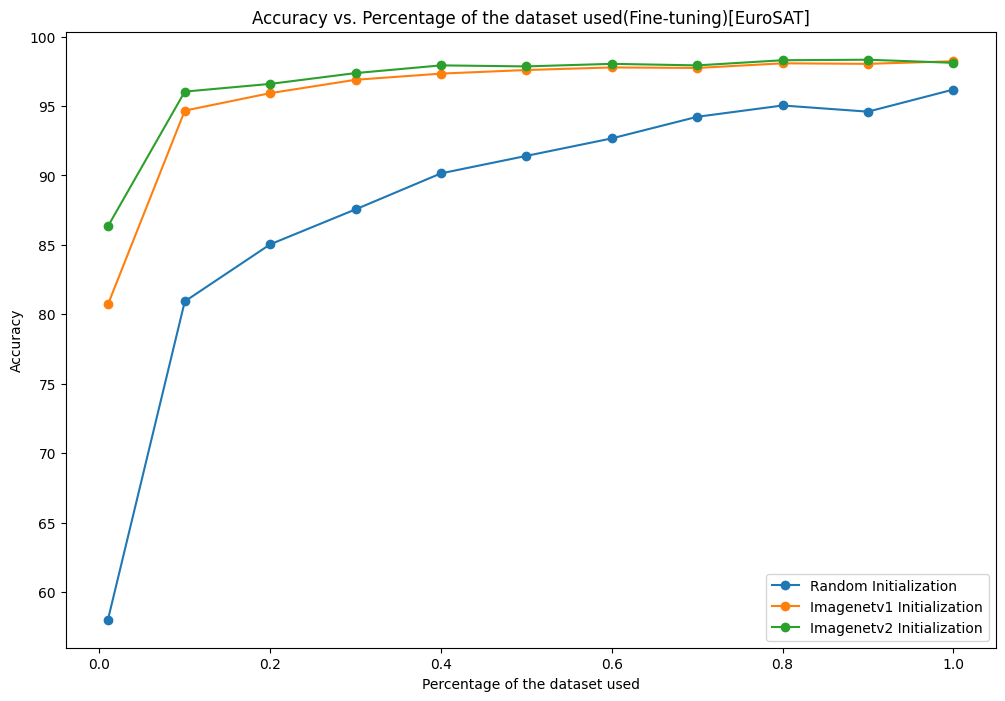

In [39]:
#plot all the list with legend
plt.figure(figsize=(12, 8))
plt.plot(percentage_list, None_fine_tuning, label='Random Initialization', marker= 'o')
plt.plot(percentage_list, Imagenetv1_fine_tuning, label='Imagenetv1 Initialization', marker= 'o')
plt.plot(percentage_list, Imagenetv2_fine_tuning, label='Imagenetv2 Initialization', marker= 'o')
plt.xlabel('Percentage of the dataset used')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Percentage of the dataset used(Fine-tuning)[EuroSAT]')
plt.savefig('/home/idisc02/Desktop/Hewan/hlcv/Why-Self-Supervision-in-Time/data/assets/finetuning.png')

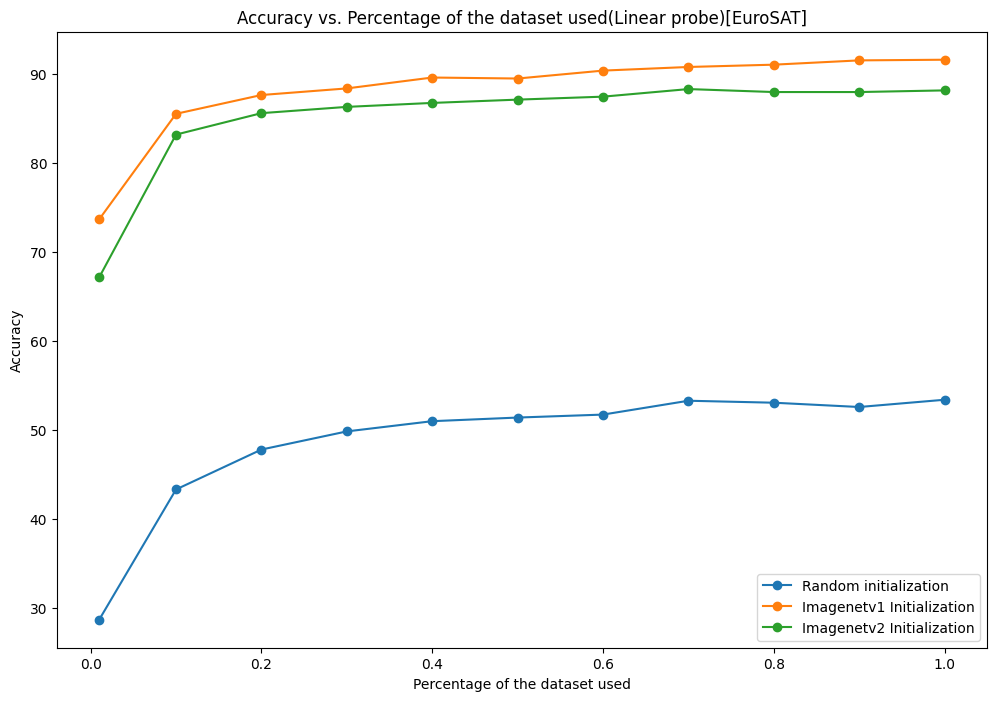

In [40]:
plt.figure(figsize=(12, 8))
plt.plot(percentage_list, None_linear_probe, label='Random initialization', marker='o')
plt.plot(percentage_list, Imagenetv1_fine_tuning_linear_probe, label='Imagenetv1 Initialization', marker='o')
plt.plot(percentage_list, Imagenetv2_fine_tuning_linear_probe, label='Imagenetv2 Initialization', marker='o')
plt.xlabel('Percentage of the dataset used')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Percentage of the dataset used(Linear probe)[EuroSAT]')
plt.savefig('/home/idisc02/Desktop/Hewan/hlcv/Why-Self-Supervision-in-Time/data/assets/linearprobe.png')


In [22]:
test_acc_dict_percentage.keys()

dict_keys(['None_fine_tuning_0.01', 'None_fine_tuning_0.1', 'None_fine_tuning_0.2', 'None_fine_tuning_0.30000000000000004', 'None_fine_tuning_0.4', 'None_fine_tuning_0.5', 'None_fine_tuning_0.6000000000000001', 'None_fine_tuning_0.7000000000000001', 'None_fine_tuning_0.8', 'None_fine_tuning_0.9', 'None_fine_tuning_1.0', 'None_linear_probe_0.01', 'None_linear_probe_0.1', 'None_linear_probe_0.2', 'None_linear_probe_0.30000000000000004', 'None_linear_probe_0.4', 'None_linear_probe_0.5', 'None_linear_probe_0.6000000000000001', 'None_linear_probe_0.7000000000000001', 'None_linear_probe_0.8', 'None_linear_probe_0.9', 'None_linear_probe_1.0', 'ResNet50_Weights.IMAGENET1K_V1_fine_tuning_0.01', 'ResNet50_Weights.IMAGENET1K_V1_fine_tuning_0.1', 'ResNet50_Weights.IMAGENET1K_V1_fine_tuning_0.2', 'ResNet50_Weights.IMAGENET1K_V1_fine_tuning_0.30000000000000004', 'ResNet50_Weights.IMAGENET1K_V1_fine_tuning_0.4', 'ResNet50_Weights.IMAGENET1K_V1_fine_tuning_0.5', 'ResNet50_Weights.IMAGENET1K_V1_fine_tu

In [16]:
test_acc_dict_percentage['None_fine_tuning_0.01']

[9.444444444444445,
 12.62962962962963,
 19.48148148148148,
 21.74074074074074,
 20.88888888888889,
 26.333333333333332,
 29.88888888888889,
 32.51851851851852,
 37.25925925925926,
 43.7037037037037,
 48.851851851851855,
 51.22222222222222,
 53.0,
 55.592592592592595,
 56.81481481481482,
 57.55555555555556,
 57.51851851851852,
 57.77777777777778,
 58.0,
 57.925925925925924]

In [6]:
train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, selected_train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device, save_dir)


Epoch 1 of 25
Epoch 1 Train results: Loss=2.5266 | Accuracy=19.92%
Epoch 1 Test results: Loss=2.3398 | Accuracy=8.33%

Epoch 2 of 25
Epoch 2 Train results: Loss=2.0315 | Accuracy=34.85%
Epoch 2 Test results: Loss=2.3334 | Accuracy=12.44%

Epoch 3 of 25
Epoch 3 Train results: Loss=1.8830 | Accuracy=41.08%
Epoch 3 Test results: Loss=2.3534 | Accuracy=9.85%

Epoch 4 of 25
Epoch 4 Train results: Loss=1.4196 | Accuracy=44.81%
Epoch 4 Test results: Loss=2.6197 | Accuracy=14.00%

Epoch 5 of 25
Epoch 5 Train results: Loss=1.1352 | Accuracy=63.49%
Epoch 5 Test results: Loss=2.6739 | Accuracy=16.74%

Epoch 6 of 25
Epoch 6 Train results: Loss=0.9658 | Accuracy=68.46%
Epoch 6 Test results: Loss=2.8618 | Accuracy=22.67%

Epoch 7 of 25
Epoch 7 Train results: Loss=0.7864 | Accuracy=75.93%
Epoch 7 Test results: Loss=2.6885 | Accuracy=28.89%

Epoch 8 of 25
Epoch 8 Train results: Loss=0.4868 | Accuracy=85.89%
Epoch 8 Test results: Loss=2.3833 | Accuracy=33.41%

Epoch 9 of 25
Epoch 9 Train results: Loss=

In [7]:
print(f'Final train loss: {train_loss[-1]}')
print(f'Final test loss: {test_loss[-1]}')
print(f'Final train accuracy: {train_accuracy[-1]}')
print(f'Final test accuracy: {test_accuracy[-1]}')

Final train loss: 0.10751461330801249
Final test loss: 1.6194383351008097
Final train accuracy: 97.09544372558594
Final test accuracy: 56.0


Plotting Graphs

In [8]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(train_loss, train_accuracy, test_loss, test_accuracy, save_dir):
    epochs = range(1, len(train_loss) + 1)

    # Plot and save the loss figure
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, test_loss, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f'{save_dir}/loss_plot.png')

    # Plot and save the accuracy figure
    plt.figure(figsize=(12, 8))
    train_accuracy_tensor = torch.Tensor(train_accuracy)
    test_accuracy_tensor = torch.Tensor(test_accuracy)

    # Move tensors to CPU and convert to NumPy arrays
    cpu_train_accuracy = train_accuracy_tensor.cpu().numpy()
    cpu_test_accuracy = test_accuracy_tensor.cpu().numpy()
    plt.plot(epochs, cpu_train_accuracy, label='Train')
    plt.plot(epochs, cpu_test_accuracy, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig(f'{save_dir}/accuracy_plot.png')

    # Show the plots
    plt.show()


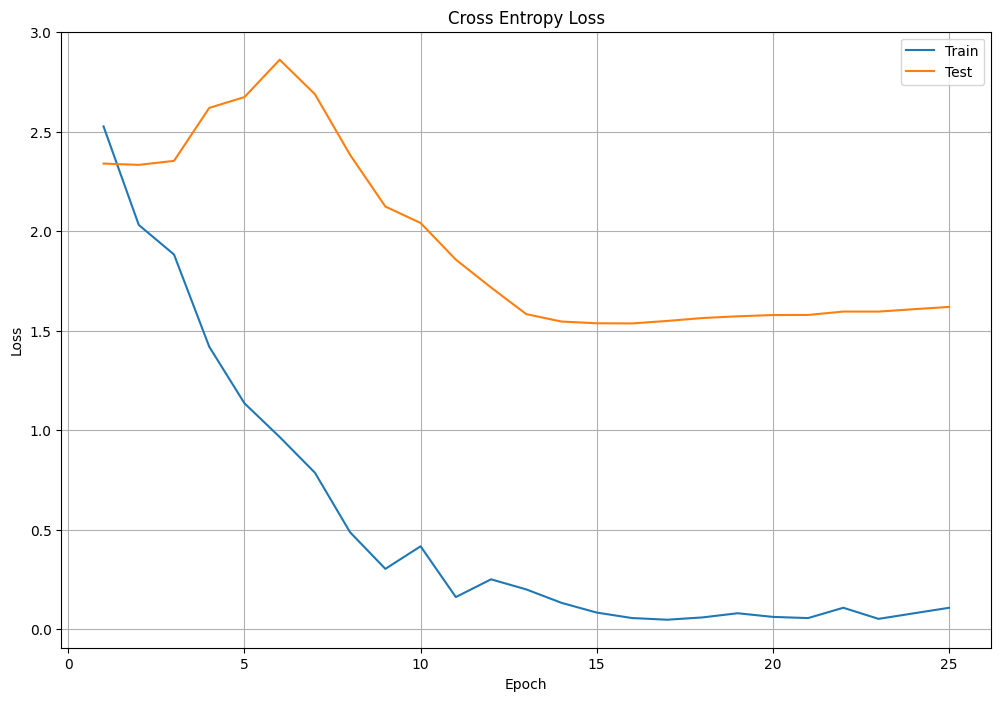

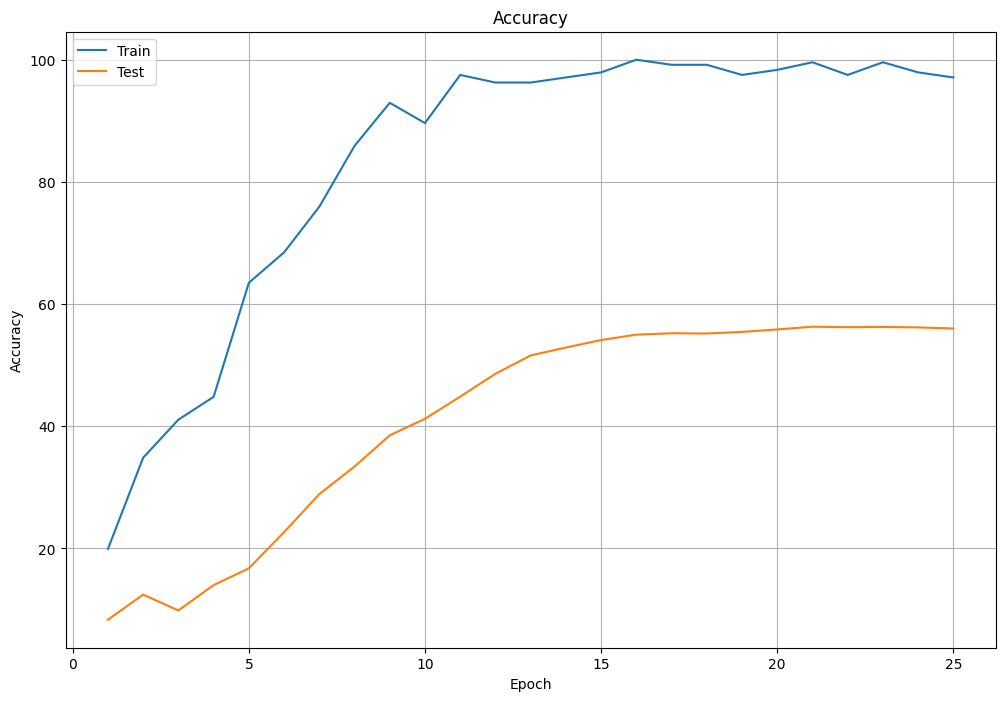

In [9]:
# Assuming you have the lists train_loss, train_accuracy, test_loss, test_accuracy defined
save_dir = "/home/idisc02/Desktop/Hewan/hlcv/Why-Self-Supervision-in-Time/data/assets"
plot_loss_and_accuracy(train_loss, train_accuracy, test_loss, test_accuracy, save_dir)


Loading Best Saved Model

In [10]:
model.load_state_dict(torch.load("/home/idisc02/Desktop/Hewan/hlcv/Why-Self-Supervision-in-Time/src/models/final_model.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
def get_random_test_samples(test_dataset, num_samples=20):
    random.seed(42)
    test_samples = []
    test_labels = []
    for sample, label in random.sample(list(test_dataset), k=num_samples):
        test_samples.append(sample)
        test_labels.append(label)
    return test_samples, test_labels

def make_predictions(model, data):
    predictions = []
    for sample in data:
        sample = torch.unsqueeze(sample, dim=0)

        # Convert the sample to a different data type if it is a boolean tensor
        if sample.dtype == torch.bool:
            sample = sample.float()  # Convert to float32

        # Move the input data to the same device as the model
        sample = sample.to(device)

        pred_logit = model(sample)
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
        predictions.append(pred_prob.detach().cpu().numpy())
    return predictions

def get_predicted_classes(pred_probs):
    pred_probs_array = np.array(pred_probs)
    pred_probs_tensor = torch.tensor(pred_probs_array)
    pred_classes = pred_probs_tensor.argmax(dim=1)
    return pred_classes

def compare_predictions(test_labels, pred_classes, class_names):
    for true_label, pred_class in zip(test_labels, pred_classes):
        true_label_name = class_names[true_label]
        pred_label_name = class_names[pred_class]
        print(f"True Label: {true_label_name} | Predicted Label: {pred_label_name}")


# Get random test samples
test_samples, test_labels = get_random_test_samples(test_dataset, num_samples=20)

# Make predictions on test samples
pred_probs = make_predictions(model, test_samples)

# Get predicted classes
pred_classes = get_predicted_classes(pred_probs)

# Compare predictions with true labels
compare_predictions(test_labels, pred_classes, class_names)


True Label: SeaLake | Predicted Label: Forest
True Label: Forest | Predicted Label: Forest
True Label: AnnualCrop | Predicted Label: Highway
True Label: Highway | Predicted Label: Pasture
True Label: Highway | Predicted Label: Highway
True Label: Highway | Predicted Label: HerbaceousVegetation
True Label: Forest | Predicted Label: Forest
True Label: Forest | Predicted Label: Forest
True Label: River | Predicted Label: PermanentCrop
True Label: Forest | Predicted Label: Forest
True Label: SeaLake | Predicted Label: SeaLake
True Label: PermanentCrop | Predicted Label: Pasture
True Label: AnnualCrop | Predicted Label: AnnualCrop
True Label: AnnualCrop | Predicted Label: AnnualCrop
True Label: Forest | Predicted Label: Forest
True Label: HerbaceousVegetation | Predicted Label: HerbaceousVegetation
True Label: Highway | Predicted Label: River
True Label: Residential | Predicted Label: Residential
True Label: SeaLake | Predicted Label: SeaLake
True Label: AnnualCrop | Predicted Label: Pastur

Displaying Outputs

In [12]:
def display_output_images(test_samples, pred_classes, test_labels, class_names):
    # Set the figure size and number of rows and columns
    plt.figure(figsize=(15, 15))
    nrows = 5
    ncols = 4

    for i, sample in enumerate(test_samples):
        # Create a subplot
        plt.subplot(nrows, ncols, i+1)

        # Convert the sample to a numpy array and transpose it if necessary
        image_data = sample.squeeze().cpu().numpy()

        # Ensure the image data has the correct shape
        if len(image_data.shape) == 3:
            image_data = image_data.transpose(1, 2, 0)

        # Normalize the pixel values to the range [0, 1]
        image_data = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

        # Plot the target image
        plt.imshow(image_data)

        # Find the prediction label (in text form, e.g. "Sandal")
        pred_label = class_names[pred_classes[i]]

        # Get the truth label (in text form, e.g. "T-shirt")
        truth_label = class_names[test_labels[i]] 

        # Create the title text of the plot
        title_text = f"Truth: {truth_label} | Pred: {pred_label}"

        # Check for equality and change title color accordingly
        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, color="g")  # Green text if correct
        else:
            plt.title(title_text, fontsize=10, color="r")  # Red text if wrong

        plt.axis(False)

    plt.show()


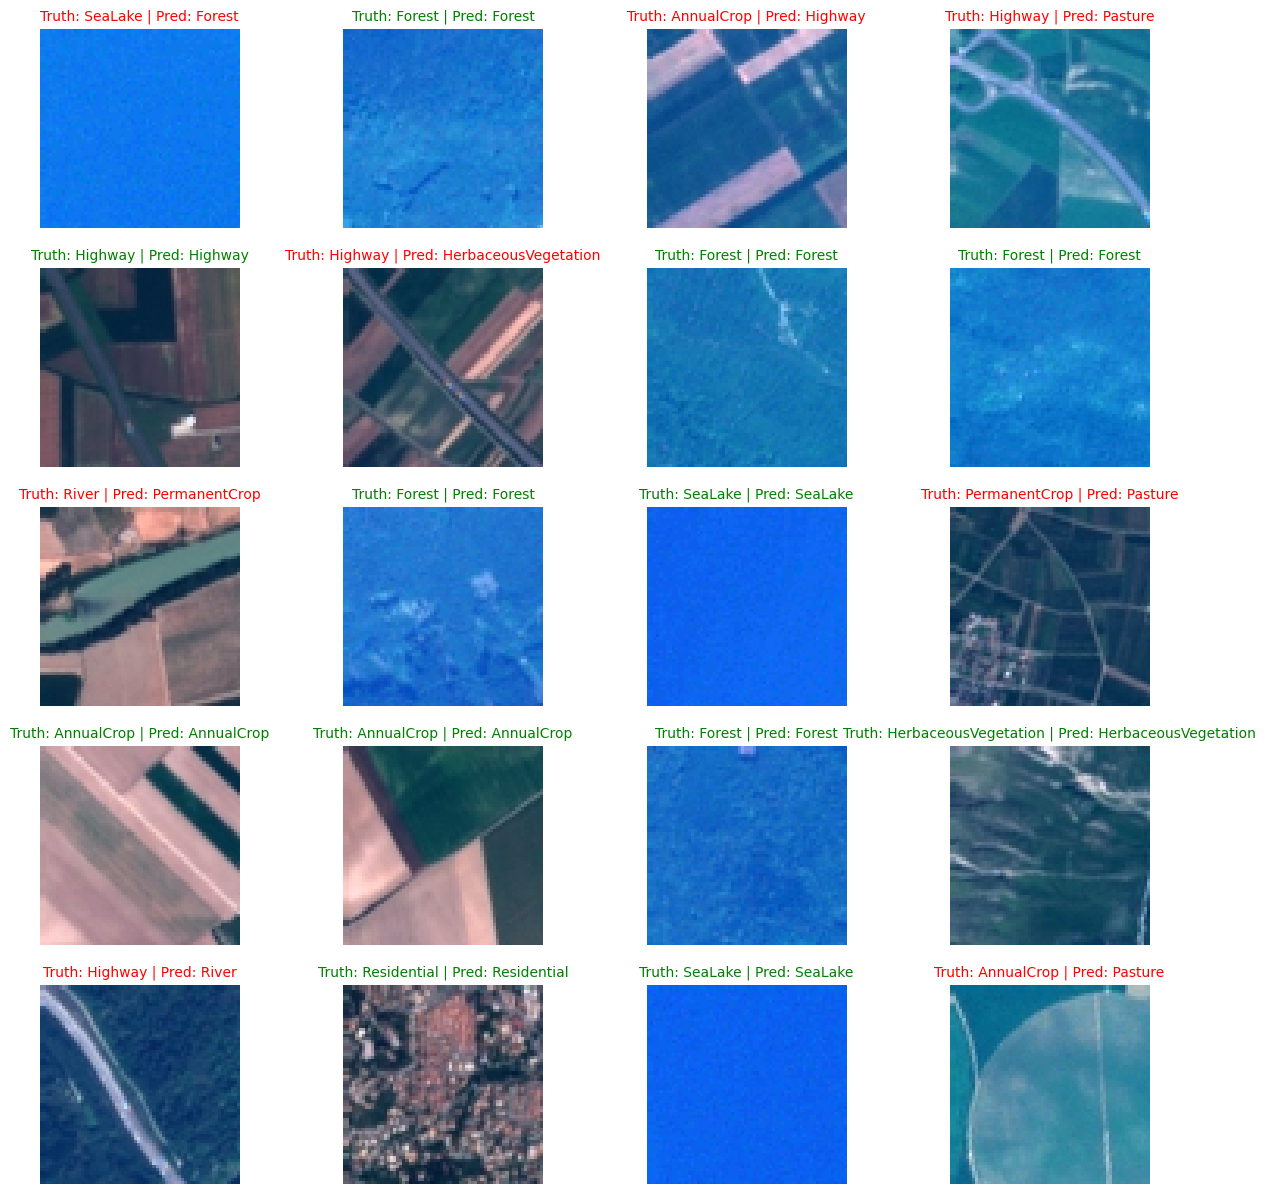

In [13]:
# Assuming you have the necessary variables defined
display_output_images(test_samples, pred_classes, test_labels, class_names)
